EJERCICIO 2 PROYECTO INVESTIGACIÓN

# Importamos las librerías necesarias:

In [14]:
import os
from PIL import Image
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import cv2
from scipy.fft import fft2
from skimage.feature import hog, local_binary_pattern
from skimage import img_as_ubyte
from sklearn.decomposition import PCA
import matplotlib as plt
from collections import Counter
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Seleccionamos los directorios de las imágenes:

In [2]:
# Definimos las rutas de las diferentes carpetas
base_path = "objects"
images_path = os.path.join(base_path, "images")
masks_path = os.path.join(base_path, "masks")
output_path = os.path.join(base_path, "output")

os.makedirs(output_path, exist_ok=True)


# Aplicamos las máscaras a las imágenes:

In [3]:

# Recorremos las carpetas de imágenes
for animal in os.listdir(images_path):
    animal_images_path = os.path.join(images_path, animal)
    animal_masks_path = os.path.join(masks_path, animal)
    animal_output_path = os.path.join(output_path, animal)

    if not os.path.isdir(animal_images_path) or not os.path.isdir(animal_masks_path):
        print(f"Carpeta faltante para {animal}, omitiendo...")
        continue

    os.makedirs(animal_output_path, exist_ok=True)

    # Recorremos las imágenes buscando la máscara correspondiente
    for image_name in sorted(os.listdir(animal_images_path)):
    
        if not image_name.startswith("image_") or not image_name.endswith(".jpg"):
            print(f"Archivo ignorado: {image_name}")
            continue

        image_number = image_name.split("_")[1].split(".")[0]  # Extrae el número de imagen
        mask_name = f"mask_{image_number}.png"
        image_path = os.path.join(animal_images_path, image_name)
        mask_path = os.path.join(animal_masks_path, mask_name)

        # Verifica que existan tanto la imagen como la máscara
        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"Faltan archivos para {image_name} y {mask_name}, omitiendo...")
            continue

        try:
            image = Image.open(image_path).convert("RGBA")  
            mask = Image.open(mask_path).convert("L")

            mask = mask.resize(image.size)

            image_array = np.array(image)
            mask_array = np.array(mask)

            # Aplicamos la máscara a la imagen
            image_array[mask_array == 0] = [0, 0, 0, 0] 

            combined_image = Image.fromarray(image_array, "RGBA")
            rgb_image = combined_image.convert("RGB")

            # Guardamos la imagen resultante en formato JPEG
            output_image_path = os.path.join(animal_output_path, image_name)
            output_image_path = output_image_path.replace(".jpg", "_combined.jpg")
            rgb_image.save(output_image_path, "JPEG")

        except Exception as e:
            print(f"Error al procesar {image_name}: {e}")

print("Proceso completado.")


Proceso completado.


# Etiquetamos las imágenes según su carpeta, y las guardamos en un csv:

In [4]:
main_folder = "objects/output"
output_csv = "image_labels.csv"

with open(output_csv, mode='w', newline='') as csvfile:

    writer = csv.writer(csvfile)
    writer.writerow(["image_path", "label"])
    
    # Recorremos las carpetas de animales
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        
        if os.path.isdir(folder_path):
            # Usamos el nombre de la carpeta como etiqueta
            label = folder
            
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                
                writer.writerow([image_path, label])

print(f"Etiquetas generadas en {output_csv}")


Etiquetas generadas en image_labels.csv


# Procesamos los datos del csv:

In [5]:
csv_file = "image_labels.csv"

image_size = (64, 64)

features = []
labels = []
# cargamos las imágenes y etiquetas del csv
processed_images = []
with open(csv_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        image_path = row["image_path"]
        label = row["label"]
        
        try:
            with Image.open(image_path) as img:
                img = img.resize(image_size).convert("L")
                img_array = np.array(img)  
                processed_images.append(img_array)
                labels.append(label)
        except Exception as e:
            print(f"Error al procesar {image_path}: {e}")


# Convertimos las listas a array de NumPy
features = np.array(features)
labels = np.array(labels)


# Cargamos los datos de nuestro csv

In [6]:
csv_file = "image_labels.csv"
image_size = (64, 64)

images = []
labels = []

with open(csv_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        image_path = row["image_path"]
        label = row["label"]
        
        try:
            with Image.open(image_path) as img:
                img = img.resize(image_size).convert("L")
                images.append(np.array(img))
                labels.append(label)
        except Exception as e:
            print(f"Error al procesar {image_path}: {e}")

images = np.array(images)
labels = np.array(labels)

# Función para poder elegir diferentes extractores de características:

In [7]:
def extract_features(images, methods=None):
    all_features = []
    
    for img in images:
        img_features = []
        
        if len(img.shape) > 2:
            img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])  
        
        if not methods:  # Si no se especifican métodos
            img_features = img.flatten()
        else:
            for method in methods:
                feature = None
                # Méthodo HOG
                if method == "hog":
                    feature = hog(
                        img, 
                        orientations=9, 
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), 
                        block_norm='L2-Hys', 
                        visualize=False
                    )
                # Método rft
                elif method == "rft":
                    fft = np.abs(fft2(img))
                    radial_profile = fft.mean(axis=1) 
                    feature = radial_profile

                # Método lbp
                elif method == "lbp":
                    radius = 1
                    n_points = 8 * radius
                    lbp = local_binary_pattern(img, n_points, radius, method="uniform")
                    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
                    lbp_hist = lbp_hist.astype(np.float32)
                    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalizar
                    feature = lbp_hist
                    
                else:
                    raise ValueError(f"Método desconocido: {method}")

                if feature is not None:
                    img_features.extend(feature.flatten())
        
        all_features.append(img_features)
    
    # Convertir lista a un array numpy, rellenar con ceros si las longitudes varían
    max_len = max(len(f) for f in all_features)
    feature_array = np.array([np.pad(f, (0, max_len - len(f)), mode='constant') for f in all_features])
    return feature_array

# Creamos una función para aplicar el downsampling a las clases flamingo y emu:

In [8]:
def balance_classes(images, labels):
    label_counts = Counter(labels)
    print("Distribución inicial:")
    print(label_counts)

    # Determinamos el número mínimo de ejemplos entre "rhino" y "elephant"
    rhino_count = label_counts['rhino']
    elephant_count = label_counts['elephant']
    
    # Se usa el mínimo de "rhino" y "elephant" para balancear las clases
    min_count = min(rhino_count, elephant_count)

    balanced_images = []
    balanced_labels = []

    for class_label in ['flamingo', 'emu', 'elephant', 'rhino']:
        class_indices = np.where(labels == class_label)[0]
        
        if class_label in ['flamingo', 'emu']:
            # Para "flamingo" y "emu", balancear reduciendo su número al mínimo entre sus propios ejemplos o min_count
            target_count = min(min_count, len(class_indices))  
            selected_indices = np.random.choice(class_indices, target_count, replace=False)

            balanced_images.extend(images[selected_indices])
            balanced_labels.extend(labels[selected_indices])

        else:
            # Para "elephant" y "rhino", no eliminamos nada, solo agregamos las imágenes
            balanced_images.extend(images[class_indices])
            balanced_labels.extend(labels[class_indices])

    balanced_images = np.array(balanced_images)
    balanced_labels = np.array(balanced_labels)

    print("Distribución después del balanceo:")
    print(Counter(balanced_labels))

    return balanced_images, balanced_labels



images, labels = balance_classes(images, labels)


Distribución inicial:
Counter({np.str_('flamingo'): 67, np.str_('elephant'): 64, np.str_('rhino'): 59, np.str_('emu'): 53})
Distribución después del balanceo:
Counter({np.str_('elephant'): 64, np.str_('flamingo'): 59, np.str_('rhino'): 59, np.str_('emu'): 53})


# Realizamos el entrenamiento con k-folds:

Distribución inicial:
Counter({np.str_('elephant'): 64, np.str_('flamingo'): 59, np.str_('rhino'): 59, np.str_('emu'): 53})
Distribución después del balanceo:
Counter({np.str_('elephant'): 64, np.str_('flamingo'): 59, np.str_('rhino'): 59, np.str_('emu'): 53})

Fold 1/15

Fold 1/15 Reporte de Clasificación:
              precision    recall  f1-score   support

    elephant       0.60      0.75      0.67         4
         emu       0.00      0.00      0.00         4
    flamingo       0.50      0.75      0.60         4
       rhino       0.75      0.75      0.75         4

    accuracy                           0.56        16
   macro avg       0.46      0.56      0.50        16
weighted avg       0.46      0.56      0.50        16

Precisión en Fold 1: 0.5625
F1 Score en Fold 1: 0.5042
Precisión en Fold 1: 0.4625
Recall en Fold 1: 0.5625

Fold 2/15

Fold 2/15 Reporte de Clasificación:
              precision    recall  f1-score   support

    elephant       1.00      1.00      1.00  

C:\Users\108057\AppData\Local\Temp\ipykernel_11932\1909888515.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


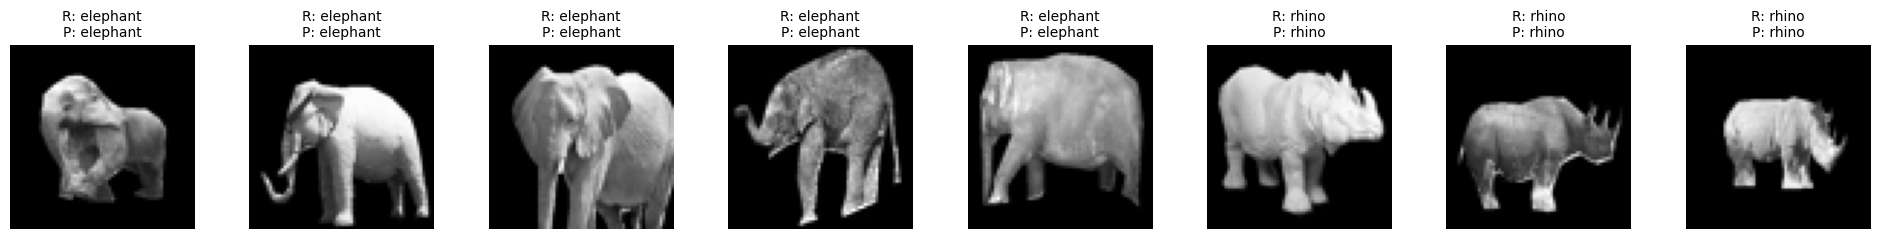


Fold 11/15 Reporte de Clasificación:
              precision    recall  f1-score   support

    elephant       0.83      1.00      0.91         5
         emu       1.00      0.33      0.50         3
    flamingo       1.00      1.00      1.00         4
       rhino       0.75      1.00      0.86         3

    accuracy                           0.87        15
   macro avg       0.90      0.83      0.82        15
weighted avg       0.89      0.87      0.84        15

Precisión en Fold 11: 0.8667
F1 Score en Fold 11: 0.8411
Precisión en Fold 11: 0.8944
Recall en Fold 11: 0.8667

Fold 12/15

Fold 12/15 Reporte de Clasificación:
              precision    recall  f1-score   support

    elephant       1.00      0.50      0.67         4
         emu       0.50      1.00      0.67         3
    flamingo       1.00      0.75      0.86         4
       rhino       0.75      0.75      0.75         4

    accuracy                           0.73        15
   macro avg       0.81      0.75      

In [32]:

images, labels = balance_classes(images, labels)
features = extract_features(images, methods = ["hog", "lbp","rft"])

k = 15
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Creamos listas para guardar los valores correspondientes en cada fold
fold_accuracies = []  
fold_f1_scores = []   
fold_precisions = []  
fold_recalls = []     
fold_dice_scores = [] 

for fold, (train_idx, test_idx) in enumerate(skf.split(features, labels)):
    print(f"\nFold {fold + 1}/{k}")
    
    X_train, X_test = features[train_idx], features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    # Le damos más peso a 'elephant' y 'rhino'
    class_weights = {'elephant': 2, 'rhino': 2, 'flamingo': 1, 'emu': 1}

    rf_model = RandomForestClassifier(class_weight=class_weights, random_state=42)
    rf_model.fit(X_train, y_train)  

    # Predicciones en el conjunto de test
    y_pred = rf_model.predict(X_test)

    # Visualización de "elephants" y "rhinos" y sus clasificaciones por el modelo:
    if fold == 10:  
        print(f"Visualización de las imágenes clasificadas en Fold {fold + 1}:")

        images_test = images[test_idx]
        y_test_fold = y_test  
        y_pred_fold = y_pred  
        
        filter_classes = ["elephant", "rhino"]
        filtered_indices = [i for i in range(len(y_test_fold)) if y_test_fold[i] in filter_classes]
        
        filtered_images = [images_test[i] for i in filtered_indices][:12]
        filtered_y_test = [y_test_fold[i] for i in filtered_indices][:12]
        filtered_y_pred = [y_pred_fold[i] for i in filtered_indices][:12]

        num_images = len(filtered_images)
        fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 5), gridspec_kw={'wspace': 0.3})

        for i, ax in enumerate(axes.flat):
            ax.imshow(filtered_images[i], cmap='gray')  
            ax.axis('off')  
            ax.set_title(f"R: {filtered_y_test[i]}\nP: {filtered_y_pred[i]}", fontsize=10)

        plt.tight_layout()
        plt.show()


    # Predicciones por clase en conjunto test
    print(f"\nFold {fold + 1}/{k} Reporte de Clasificación:")
    report = classification_report(y_test, y_pred, zero_division=1)
    print(report) 
        
    # Calculamos las métricas y las guardamos
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    
    fold_accuracies.append(accuracy)
    fold_f1_scores.append(f1)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    
    print(f"Precisión en Fold {fold + 1}: {accuracy:.4f}")
    print(f"F1 Score en Fold {fold + 1}: {f1:.4f}")
    print(f"Precisión en Fold {fold + 1}: {precision:.4f}")
    print(f"Recall en Fold {fold + 1}: {recall:.4f}")

# Resultados finales
print("\nResultados de k-Fold Cross-Validation:")
print("------------------------------------------------------------------")
print(f"Exactitud promedio: {np.mean(fold_accuracies):.4f}")
print(f"Desviación estándar de la exactitud: {np.std(fold_accuracies):.4f}")
print("------------------------------------------------------------------")
print(f"F1 Score promedio: {np.mean(fold_f1_scores):.4f}")
print(f"Desviación estándar del F1 Score: {np.std(fold_f1_scores):.4f}")
print("------------------------------------------------------------------")
print(f"Precisión promedio: {np.mean(fold_precisions):.4f}")
print(f"Desviación estándar de la precisión: {np.std(fold_precisions):.4f}")
print("------------------------------------------------------------------")
print(f"Recall promedio: {np.mean(fold_recalls):.4f}")
print(f"Desviación estándar del recall: {np.std(fold_recalls):.4f}")
print("------------------------------------------------------------------")


